In [30]:
# Initialize OK
from client.api.notebook import Notebook
ok = Notebook('proj1.ok')

Assignment: proj1
OK, version v1.13.11



# Project 1: Food Safety 
## Cleaning and Exploring Data with Pandas

**Collaborators**: *Tessa de Vries, Avery Byrne*


## This Assignment

In this project, you will investigate restaurant food safety scores for restaurants in San Francisco. Above is a sample score card for a restaurant. The scores and violation information have been made available by the San Francisco Department of Public Health. The main goal for this assignment is to understand how restaurants are scored. We will walk through various steps of exploratory data analysis to do this. We will provide comments and insights along the way to give you a sense of how we arrive at each discovery and what next steps it leads to.

As we clean and explore these data, we will:
* Read simple csv files
* Work with data at different levels of granularity
* Identif the type of data collected, missing values, anomalies, etc.
* Explore characteristics and distributions of individual variables

Setting up some imports and the automatic tests that we will need for this assignment:

In [32]:
%matplotlib inline
import pandas as pd
import numpy as np
import zipfile
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

In [33]:
import sys

assert 'zipfile'in sys.modules
assert 'pandas'in sys.modules and pd
assert 'numpy'in sys.modules and np
assert 'matplotlib'in sys.modules and plt

## Downloading the Data

For this assignment, we need this data file: http://www.ds100.org/fa19/assets/datasets/proj1-SFBusinesses.zip

In [33]:
import ds100_utils
source_data_url = 'http://www.ds100.org/fa19/assets/datasets/proj1-SFBusinesses.zip'
target_file_name = 'data.zip'

# Change the force=False -> force=True in case you need to force redownload the data
dest_path = ds100_utils.fetch_and_cache(
    data_url=source_data_url, 
    data_dir='.', 
    file=target_file_name, 
    force=False)

Using cached version that was downloaded (UTC): Mon Sep 16 19:06:13 2019


After running the cell above, if you list the contents of the directory containing this notebook, you should see `data.zip`.

*Note*: The command below starts with an `!`. This tells our Jupyter notebook to pass this command to the operating system. In this case, the command is the `ls` Unix command which lists files in the current directory.

In [34]:
!ls

data		proj1.ipynb  __pycache__  q7d.png	 test.tplx
data.zip	proj1.ok     q6a.png	  scoreCard.jpg
ds100_utils.py	proj1.pdf    q7c2.png	  tests


## 1: Loading Food Safety Data

Some questions we want to answer:

* Is the data in a standard format or encoding?
* Is the data organized in records?
* What are the fields in each record?

### Question 1a: Looking Inside and Extracting the Zip Files

Assign `my_zip` to a `zipfile.Zipfile` object representing `data.zip`, and assign `list_files` to a list of all the names of the files in `data.zip`.

*Hint*: The [Python docs](https://docs.python.org/3/library/zipfile.html) describe how to create a `zipfile.ZipFile` object. You might also look back at the code from lecture and lab 4's optional hacking challenge. It's OK to copy and paste code from previous assignments and demos, though you might get more out of this exercise if you type out an answer.

<!--
BEGIN QUESTION
name: q1a
points: 1
-->

In [35]:
my_zip = zipfile.ZipFile(dest_path, mode='r')
list_names = my_zip.namelist()
list_names

['violations.csv', 'businesses.csv', 'inspections.csv', 'legend.csv']

In [36]:
ok.grade("q1a");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 3
    Failed: 0
[ooooooooook] 100.0% passed



Now display the files' names and their sizes.


In [37]:
my_zip.infolist()

[<ZipInfo filename='violations.csv' compress_type=deflate external_attr=0x20 file_size=3726206 compress_size=286253>,
 <ZipInfo filename='businesses.csv' compress_type=deflate external_attr=0x20 file_size=660231 compress_size=178549>,
 <ZipInfo filename='inspections.csv' compress_type=deflate external_attr=0x20 file_size=466106 compress_size=83198>,
 <ZipInfo filename='legend.csv' compress_type=deflate external_attr=0x20 file_size=120 compress_size=104>]

The cell below will unzip the csv files into a subdirectory called `data`.

In [38]:
from pathlib import Path
data_dir = Path('data')
my_zip.extractall(data_dir)
!ls {data_dir}

businesses.csv	inspections.csv  legend.csv  violations.csv


The cell above created a folder called `data`, and in it there should be four CSV files.

### Question 1b: Programatically Looking Inside the Files

The `legend.csv` file does indeed look like a well-formed CSV file. Let's check the other three files by printing out the first 5 lines of each. The `ds100_utils` library has a method called `head` that will allow you to retrieve the first N lines of a file as a list.

In [39]:
display(ds100_utils.head('data/violations.csv'),
        ds100_utils.head('data/businesses.csv'),
        ds100_utils.head('data/inspections.csv'),
        ds100_utils.head('data/legend.csv'))

['"business_id","date","description"\n',
 '19,"20171211","Inadequate food safety knowledge or lack of certified food safety manager"\n',
 '19,"20171211","Unapproved or unmaintained equipment or utensils"\n',
 '19,"20160513","Unapproved or unmaintained equipment or utensils  [ date violation corrected: 12/11/2017 ]"\n',
 '19,"20160513","Unclean or degraded floors walls or ceilings  [ date violation corrected: 12/11/2017 ]"\n']

['"business_id","name","address","city","state","postal_code","latitude","longitude","phone_number"\n',
 '19,"NRGIZE LIFESTYLE CAFE","1200 VAN NESS AVE, 3RD FLOOR","San Francisco","CA","94109","37.786848","-122.421547","+14157763262"\n',
 '24,"OMNI S.F. HOTEL - 2ND FLOOR PANTRY","500 CALIFORNIA ST, 2ND  FLOOR","San Francisco","CA","94104","37.792888","-122.403135","+14156779494"\n',
 '31,"NORMAN\'S ICE CREAM AND FREEZES","2801 LEAVENWORTH ST ","San Francisco","CA","94133","37.807155","-122.419004",""\n',
 '45,"CHARLIE\'S DELI CAFE","3202 FOLSOM ST ","San Francisco","CA","94110","37.747114","-122.413641","+14156415051"\n']

['"business_id","score","date","type"\n',
 '19,"94","20160513","routine"\n',
 '19,"94","20171211","routine"\n',
 '24,"98","20171101","routine"\n',
 '24,"98","20161005","routine"\n']

['"Minimum_Score","Maximum_Score","Description"\n',
 '0,70,"Poor"\n',
 '71,85,"Needs Improvement"\n',
 '86,90,"Adequate"\n',
 '91,100,"Good"\n']

### Question 1c: Reading in the Files

Based on the above information, let's attempt to load `businesses.csv`, `inspections.csv`, and `violations.csv` into pandas dataframes with the following names: `bus`, `ins`, and `vio` respectively.

*Note:* Because of character encoding issues one of the files (`bus`) will require an additional argument `encoding='ISO-8859-1'` when calling `pd.read_csv`. At some point in your future, you should read all about [character encodings](https://www.diveinto.org/python3/strings.html). We won't discuss these in detail in DS100.

In [40]:
# path to directory containing data
dsDir = Path('data')

bus = pd.read_csv(dsDir/"businesses.csv",encoding='ISO-8859-1') 
ins = pd.read_csv(dsDir/"inspections.csv") 
vio = pd.read_csv(dsDir/"violations.csv") 

Show the top few lines of the `bus`, `ins`, and `vio` dataframes.

In [41]:
display(pd.DataFrame.head(bus),pd.DataFrame.head(ins),pd.DataFrame.head(vio))

,business_id,name,address,city,state,postal_code,latitude,longitude,phone_number
0,19,NRGIZE LIFESTYLE CAFE,"1200 VAN NESS AVE, 3RD FLOOR",San Francisco,CA,94109,37.786848,-122.421547,+14157763262
1,24,OMNI S.F. HOTEL - 2ND FLOOR PANTRY,"500 CALIFORNIA ST, 2ND FLOOR",San Francisco,CA,94104,37.792888,-122.403135,+14156779494
2,31,NORMAN'S ICE CREAM AND FREEZES,2801 LEAVENWORTH ST,San Francisco,CA,94133,37.807155,-122.419004,NaN
3,45,CHARLIE'S DELI CAFE,3202 FOLSOM ST,San Francisco,CA,94110,37.747114,-122.413641,+14156415051
4,48,ART'S CAFE,747 IRVING ST,San Francisco,CA,94122,37.764013,-122.465749,+14156657440


,business_id,score,date,type
0,19,94,20160513,routine
1,19,94,20171211,routine
2,24,98,20171101,routine
3,24,98,20161005,routine
4,24,96,20160311,routine


,business_id,date,description
0,19,20171211,Inadequate food safety knowledge or lack of ce...
1,19,20171211,Unapproved or unmaintained equipment or utensils
2,19,20160513,Unapproved or unmaintained equipment or utensi...
3,19,20160513,Unclean or degraded floors walls or ceilings ...
4,19,20160513,Food safety certificate or food handler card n...


The `DataFrame.describe` method can also be handy for computing summaries of various statistics of our dataframes.

In [42]:
display(pd.DataFrame.describe(bus),pd.DataFrame.describe(ins),pd.DataFrame.describe(vio))

,business_id,latitude,longitude
count,6406.000000,3270.000000,3270.000000
mean,53058.248049,37.773662,-122.425791
std,34928.238762,0.022910,0.027762
min,19.000000,37.668824,-122.510896
25%,7405.500000,37.760487,-122.436844
50%,68294.500000,37.780435,-122.418855
75%,83446.500000,37.789951,-122.406609
max,94574.000000,37.824494,-122.368257


,business_id,score,date
count,14222.000000,14222.000000,1.422200e+04
mean,45138.752637,90.697370,2.016242e+07
std,34497.913056,8.088705,8.082778e+03
min,19.000000,48.000000,2.015013e+07
25%,5634.000000,86.000000,2.016021e+07
50%,61462.000000,92.000000,2.016091e+07
75%,78074.000000,96.000000,2.017061e+07
max,94231.000000,100.000000,2.018012e+07


,business_id,date
count,39042.000000,3.904200e+04
mean,45674.440244,2.016283e+07
std,34172.433276,7.874679e+03
min,19.000000,2.015013e+07
25%,4959.000000,2.016031e+07
50%,62060.000000,2.016092e+07
75%,77681.000000,2.017063e+07
max,94231.000000,2.018012e+07


## Question 1d: Verifying the data

Now let's run the automated tests. If your dataframes are correct, then the following cell will seem to do nothing, which is a good thing! However, if your variables don't match the correct answers in the main summary statistics shown above, an exception will be raised.

<!--
BEGIN QUESTION
name: q1d
points: 3
-->

In [45]:
"""Run this cell to load this utility comparison function that we will use in various
tests below (both tests you can see and those we run internally for grading).

Do not modify the function in any way.
"""


def df_allclose(actual, desired, columns=None, rtol=5e-2):
    """Compare selected columns of two dataframes on a few summary statistics.
    
    Compute the min, median and max of the two dataframes on the given columns, and compare
    that they match numerically to the given relative tolerance.
    
    If they don't match, an AssertionError is raised (by `numpy.testing`).
    """    
    # summary statistics to compare on
    stats = ['min', '50%', 'max']
    
    # For the desired values, we can provide a full DF with the same structure as
    # the actual data, or pre-computed summary statistics.
    # We assume a pre-computed summary was provided if columns is None. In that case, 
    # `desired` *must* have the same structure as the actual's summary
    if columns is None:
        des = desired
        columns = desired.columns
    else:
        des = desired[columns].describe().loc[stats]

    # Extract summary stats from actual DF
    act = actual[columns].describe().loc[stats]

    return np.allclose(act, des, rtol)

In [46]:
ok.grade("q1d");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 3
    Failed: 0
[ooooooooook] 100.0% passed



### Question 1e: Identifying Issues with the Data

Use the `head` command on your three files again. This time, describe at least one potential problem with the data you see. Consider issues with missing values and bad data.

<!--
BEGIN QUESTION
name: q1e
manual: True
points: 1
-->
<!-- EXPORT TO PDF -->

*One potential problem with the data that I see is in regards to bad data. Specifically, the dates in the data are badly formatted and difficult to interpret. The dates show as merely a string of numbers (i.e '20160513') with no clear distinction as to what numbers represent the day, month, or year. Without the dates being correctly formatted, the data values are diffucult to use for analysis.*



We will explore each file in turn, including determining its granularity and primary keys and exploring many of the variables individually. Let's begin with the businesses file, which has been read into the `bus` dataframe.

---
## 2: Examining the Business Data

From its name alone, we expect the `businesses.csv` file to contain information about the restaurants. Let's investigate the granularity of this dataset.

### Question 2a

Examining the entries in `bus`, is the `business_id` unique for each record that is each row of data? Your code should compute the answer, i.e. don't just hard code `True` or `False`.

Hint: use `value_counts()` or `unique()` to determine if the `business_id` series has any duplicates.

<!--
BEGIN QUESTION
name: q2a
points: 1
-->

In [47]:
is_business_id_unique = (len(bus["business_id"].unique())) == (len(bus["business_id"]))

In [48]:
ok.grade("q2a");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 2
    Failed: 0
[ooooooooook] 100.0% passed



### Question 2b

With this information, you can address the question of granularity. Answer the questions below.

1. What does each record represent (e.g., a business, a restaurant, a location, etc.)?  
1. What is the primary key?
1. What would you find by grouping by the following columns: `business_id`, `name`, `address` each individually?

Please write your answer in the markdown cell below. You may create new cells below your answer to run code, but **please never add cells between a question cell and the answer cell below it.**

<!--
BEGIN QUESTION
name: q2b
points: 2
manual: True
-->
<!-- EXPORT TO PDF -->

*1. Each record represents a business and its corresponding location information. This location information includes metrics like address, latitude and longitude.*

*2. The primary key is the business id.*

*3. When grouping by the following columns individually, each dataframe returned is the same as the original 'bus' data frame.*


In [49]:
bus.groupby('name').head(4)

,business_id,name,address,city,state,postal_code,latitude,longitude,phone_number
0,19,NRGIZE LIFESTYLE CAFE,"1200 VAN NESS AVE, 3RD FLOOR",San Francisco,CA,94109,37.786848,-122.421547,+14157763262
1,24,OMNI S.F. HOTEL - 2ND FLOOR PANTRY,"500 CALIFORNIA ST, 2ND FLOOR",San Francisco,CA,94104,37.792888,-122.403135,+14156779494
2,31,NORMAN'S ICE CREAM AND FREEZES,2801 LEAVENWORTH ST,San Francisco,CA,94133,37.807155,-122.419004,NaN
3,45,CHARLIE'S DELI CAFE,3202 FOLSOM ST,San Francisco,CA,94110,37.747114,-122.413641,+14156415051
4,48,ART'S CAFE,747 IRVING ST,San Francisco,CA,94122,37.764013,-122.465749,+14156657440
...,...,...,...,...,...,...,...,...,...
6401,94544,D'MAIZE CAFE,50 PHELAN AVE,San Francisco,CA,94112,NaN,NaN,+14154240604
6402,94555,EASY BREEZY FROZEN YOGURT,44 WEST PORTAL AVE,San Francisco,CA,94127,NaN,NaN,+14155053351
6403,94571,THE PHOENIX PASTIFICIO,200 CLEMENT ST,San Francisco,CA,94118,NaN,NaN,+14154726100
6404,94572,BROADWAY DIM SUM CAFE,684 BROADWAY ST,San Francisco,CA,94133,NaN,NaN,NaN


---
## 3: Zip Codes

Next, let's  explore some of the variables in the business table. We begin by examining the postal code.

### Question 3a

Answer the following questions about the `postal code` column in the `bus` data frame?  
1. Are ZIP codes quantitative or qualitative? If qualitative, is it ordinal or nominal? 
1. What data type is used to represent a ZIP code?

*Note*: ZIP codes and postal codes are the same thing.

<!--
BEGIN QUESTION
name: q3a
points: 2
manual: True
-->
<!-- EXPORT TO PDF -->

*1. Zip codes are qualitative because calculations on such numbers like addition or averages does not provide meaningful information. Though zipcodes are numeric, mathmatical opearations using such numbers do not allow for insight into data. Zipcode are qualitative as they categorize by geographic location.*

*2. The data type used to represent a zip code is an integer.*

### Question 3b

How many restaurants are in each ZIP code? 

In the cell below, create a series where the index is the postal code and the value is the number of records with that postal code in descending order of count. 94110 should be at the top with a count of 596. You'll need to use `groupby()`. You may also want to use `.size()` or `.value_counts()`. 

<!--
BEGIN QUESTION
name: q3b
points: 0
-->

In [50]:
zip_counts = bus.groupby('postal_code').size().sort_values(ascending=False)
zip_counts.head()

postal_code
94110    596
94103    552
94102    462
94107    460
94133    426
dtype: int64

Did you take into account that some businesses have missing ZIP codes?

In [51]:
print('zip_counts describes', sum(zip_counts), 'records.')
print('The original data have', len(bus), 'records')

zip_counts describes 6166 records.
The original data have 6406 records


Missing data is extremely common in real-world data science projects. There are several ways to include missing postal codes in the `zip_counts` series above. One approach is to use the `fillna` method of the series, which will replace all null (a.k.a. NaN) values with a string of our choosing. In the example below, we picked "?????". When you run the code below, you should see that there are 240 businesses with missing zip code.

In [52]:
zip_counts = bus.fillna("?????").groupby("postal_code").size().sort_values(ascending=False)
zip_counts.head(15)

postal_code
94110    596
94103    552
94102    462
94107    460
94133    426
94109    380
94111    277
94122    273
94118    249
94115    243
?????    240
94105    232
94108    228
94114    223
94117    204
dtype: int64

An alternate approach is to use the DataFrame `value_counts` method with the optional argument `dropna=False`, which will ensure that null values are counted. In this case, the index will be `NaN` for the row corresponding to a null postal code.

In [53]:
bus["postal_code"].value_counts(dropna=False).sort_values(ascending = False).head(15)

94110    596
94103    552
94102    462
94107    460
94133    426
94109    380
94111    277
94122    273
94118    249
94115    243
NaN      240
94105    232
94108    228
94114    223
94117    204
Name: postal_code, dtype: int64

Missing zip codes aren't our only problem. There are also some records where the postal code is wrong, e.g., there are 3 'Ca' and 3 'CA' values. Additionally, there are some extended postal codes that are 9 digits long, rather than the typical 5 digits. We will dive deeper into problems with postal code entries in subsequent questions. 

For now, let's clean up the extended zip codes by dropping the digits beyond the first 5. Rather than deleting or replacing the old values in the `postal_code` columnm, we'll instead create a new column called `postal_code_5`.

The reason we're making a new column is that it's typically good practice to keep the original values when we are manipulating data. This makes it easier to recover from mistakes, and also makes it more clear that we are not working with the original raw data.

In [54]:
bus['postal_code_5'] = bus['postal_code'].str[:5]
bus.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,phone_number,postal_code_5
0,19,NRGIZE LIFESTYLE CAFE,"1200 VAN NESS AVE, 3RD FLOOR",San Francisco,CA,94109,37.786848,-122.421547,+14157763262,94109
1,24,OMNI S.F. HOTEL - 2ND FLOOR PANTRY,"500 CALIFORNIA ST, 2ND FLOOR",San Francisco,CA,94104,37.792888,-122.403135,+14156779494,94104
2,31,NORMAN'S ICE CREAM AND FREEZES,2801 LEAVENWORTH ST,San Francisco,CA,94133,37.807155,-122.419004,NaN,94133
3,45,CHARLIE'S DELI CAFE,3202 FOLSOM ST,San Francisco,CA,94110,37.747114,-122.413641,+14156415051,94110
4,48,ART'S CAFE,747 IRVING ST,San Francisco,CA,94122,37.764013,-122.465749,+14156657440,94122


### Question 3c : A Closer Look at Missing ZIP Codes

Let's look more closely at records with missing ZIP codes. Describe why some records have missing postal codes.  Pay attention to their addresses. You will need to look at many entries, not just the first five.

*Hint*: The `isnull` method of a series returns a boolean series which is true only for entries in the original series that were missing.

<!--
BEGIN QUESTION
name: q3c
points: 2
manual: True
-->
<!-- EXPORT TO PDF -->

*Some records may have missing postal codes because they have multiple locations or are actually located in a different city than San Francisco. Another reason some records may have missing postal codes is because the business has permanently closed.*



In [55]:
bus[pd.isnull(bus["postal_code"])]

,business_id,name,address,city,state,postal_code,latitude,longitude,phone_number,postal_code_5
1702,8202,XIAO LOONG,250 WEST PORTAL AVENUE,San Francisco,CA,NaN,37.738616,-122.468775,+14152792647,NaN
1725,9358,EDGEWOOD CHILDREN'S CENTER,1801 VICENTE ST,San Francisco,CA,NaN,37.739083,-122.485437,NaN,NaN
1731,9582,DIMPLES,1700 POST ST.,San Francisco,CA,NaN,37.785632,-122.429794,+14155190341,NaN
1747,10011,OSHA THAI NOODLE,819 VALENCIA ST.,San Francisco,CA,NaN,37.759943,-122.421332,+14153109293,NaN
1754,10227,THE NAPPER TANDY,3200 24TH ST,San Francisco,CA,NaN,37.752581,-122.416482,+14155507510,NaN
...,...,...,...,...,...,...,...,...,...,...
6194,92563,LA BOULANGERIE DE SAN FRANCISCO,655 MONTGOMERY ST,San Francisco,CA,NaN,NaN,NaN,+14158239635,NaN
6223,92857,"MOBI MUNCH, INC.",OFF THE GRID,San Francisco,CA,NaN,NaN,NaN,+14152899800,NaN
6240,93029,BAHN MI ZON,OFF THE GRID,San Francisco,CA,NaN,NaN,NaN,+14152414342,NaN
6354,94123,BON APPETIT @ AIRBNB,999 BRANNAN ST,San Francisco,CA,NaN,NaN,NaN,+1415 Alieri,NaN


### Question 3d: Incorrect ZIP Codes

This dataset is supposed to be only about San Francisco, so let's set up a list of all San Francisco ZIP codes.

In [56]:
all_sf_zip_codes = ["94102", "94103", "94104", "94105", "94107", "94108", 
                    "94109", "94110", "94111", "94112", "94114", "94115", 
                    "94116", "94117", "94118", "94119", "94120", "94121", 
                    "94122", "94123", "94124", "94125", "94126", "94127", 
                    "94128", "94129", "94130", "94131", "94132", "94133", 
                    "94134", "94137", "94139", "94140", "94141", "94142", 
                    "94143", "94144", "94145", "94146", "94147", "94151", 
                    "94158", "94159", "94160", "94161", "94163", "94164", 
                    "94172", "94177", "94188"]

Set `weird_zip_code_businesses` equal to a new dataframe that contains only rows corresponding to ZIP codes that are 'weird'. We define weird as any zip code which has both of the following 2 properties: 

1. The zip code is not valid: Either not 5-digit long or not a San Francisco zip code.

2. The zip is not missing. 

Use the `postal_code_5` column.

*Hint*: The `~` operator inverts a boolean array. Use in conjunction with `isin` from lecture 3.

<!--
BEGIN QUESTION
name: q3d1
points: 0
-->

In [57]:
weird_zip_code_businesses = bus[~bus['postal_code_5'].isin(all_sf_zip_codes) & ~(bus.isnull()['postal_code_5'])]
weird_zip_code_businesses

,business_id,name,address,city,state,postal_code,latitude,longitude,phone_number,postal_code_5
1211,5208,GOLDEN GATE YACHT CLUB,1 YACHT RD,San Francisco,CA,941,37.807878,-122.442499,+14153462628,941
1372,5755,J & J VENDING,VARIOUS LOACATIONS (17),San Francisco,CA,94545,NaN,NaN,+14156750910,94545
1373,5757,"RICO VENDING, INC",VARIOUS LOCATIONS,San Francisco,CA,94066,NaN,NaN,+14155836723,94066
2258,36547,EPIC ROASTHOUSE,PIER 26 EMBARARCADERO,San Francisco,CA,95105,37.788962,-122.387941,+14153699955,95105
2293,37167,INTERCONTINENTAL SAN FRANCISCO EMPLOYEE CAFETERIA,888 HOWARD ST 2ND FLOOR,San Francisco,CA,94013,37.781664,-122.404778,+14156166532,94013
2295,37169,INTERCONTINENTAL SAN FRANCISCO 4TH FL. KITCHEN,888 HOWARD ST 4TH FLOOR,San Francisco,CA,94013,37.781664,-122.404778,+14156166532,94013
2846,64540,LEO'S HOT DOGS,2301 MISSION ST,San Francisco,CA,CA,37.760054,-122.419166,+14152406434,CA
2852,64660,HAIGHT STREET MARKET,1530 HAIGHT ST,San Francisco,CA,92672,37.769957,-122.447533,+14152550643,92672
2857,64738,JAPACURRY,PUBLIC,San Francisco,CA,CA,37.777122,-122.419639,+14152444785,CA
2969,65856,BAMBOO ASIA,41 MONTGOMERY ST,San Francisco,CA,94101,37.774998,-122.418299,+14156246790,94101


If we were doing very serious data analysis, we might indivdually look up every one of these strange records. Let's focus on just two of them: ZIP codes 94545 and 94602. Use a search engine to identify what cities these ZIP codes appear in. Try to explain why you think these two ZIP codes appear in your dataframe. For the one with ZIP code 94602, try searching for the business name and locate its real address.
<!--
BEGIN QUESTION
name: q3d2
points: 1
manual: True
-->
<!-- EXPORT TO PDF -->

*The zipcode 94545 is Hayward,CA and the zipcode 94602 is Oakland,CA. When searching for the business with the zip code 94602, its real zipcode is 94102. These two zipcodes appear in the data frame because they are near to the San Francisco zip code. The business with zip code 94602 corresponds to the business caled 'Orbit Room' and its address is 1900 Market St, San Francisco, CA 94102*

### Question 3e

We often want to clean the data to improve our analysis. This cleaning might include changing values for a variable or dropping records.

The value 94602 is wrong. Change it to the most reasonable correct value, using all information you have available from your internet search for real world business. Modify the `postal_code_5` field using `bus['postal_code_5'].str.replace` to replace 94602.

<!--
BEGIN QUESTION
name: q3e
points: 1
-->

In [58]:
# WARNING: Be careful when uncommenting the line below, it will set the entire column to NaN unless you 
# put something to the right of the ellipses.
bus['postal_code_5'] = bus['postal_code_5'].str.replace('94602', '94102')

In [59]:
ok.grade("q3e");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



### Question 3f

Now that we have corrected one of the weird postal codes, let's filter our `bus` data such that only postal codes from San Francisco remain. While we're at it, we'll also remove the businesses that are missing a postal code. As we mentioned in question 3d, filtering our postal codes in this way may not be ideal. (Fortunately, this is just a course assignment.) Use the `postal_code_5` column.

Assign `bus` to a new dataframe that has the same columns but only the rows with ZIP codes in San Francisco.

<!--
BEGIN QUESTION
name: q3f
points: 1
-->

In [60]:
bus = bus[bus['postal_code_5'].isin(all_sf_zip_codes)]
bus.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,phone_number,postal_code_5
0,19,NRGIZE LIFESTYLE CAFE,"1200 VAN NESS AVE, 3RD FLOOR",San Francisco,CA,94109,37.786848,-122.421547,+14157763262,94109
1,24,OMNI S.F. HOTEL - 2ND FLOOR PANTRY,"500 CALIFORNIA ST, 2ND FLOOR",San Francisco,CA,94104,37.792888,-122.403135,+14156779494,94104
2,31,NORMAN'S ICE CREAM AND FREEZES,2801 LEAVENWORTH ST,San Francisco,CA,94133,37.807155,-122.419004,NaN,94133
3,45,CHARLIE'S DELI CAFE,3202 FOLSOM ST,San Francisco,CA,94110,37.747114,-122.413641,+14156415051,94110
4,48,ART'S CAFE,747 IRVING ST,San Francisco,CA,94122,37.764013,-122.465749,+14156657440,94122


In [61]:
ok.grade("q3f");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



---
## 4: Latitude and Longitude

Let's also consider latitude and longitude values in the `bus` data frame and get a sense of how many are missing.

### Question 4a

How many businesses are missing longitude values?

*Hint*: Use `isnull`.

<!--
BEGIN QUESTION
name: q4a1
points: 1
-->

In [62]:
num_missing_longs = bus['longitude'].isnull().sum()
num_missing_longs

2942

In [63]:
ok.grade("q4a1");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



As a somewhat contrived exercise in data manipulation, let's try to identify which ZIP codes are missing the most longitude values.

Throughout problems 4a and 4b, let's focus on only the "dense" ZIP codes of the city of San Francisco, listed below as `sf_dense_zip`.

In [64]:
sf_dense_zip = ["94102", "94103", "94104", "94105", "94107", "94108",
                "94109", "94110", "94111", "94112", "94114", "94115",
                "94116", "94117", "94118", "94121", "94122", "94123", 
                "94124", "94127", "94131", "94132", "94133", "94134"]

In the cell below, create a series where the index is `postal_code_5`, and the value is the number of businesses with missing longitudes in that ZIP code. Your series should be in descending order (the values should be in descending order). The first two rows of your answer should include postal code 94103 and 94110. Only businesses from `sf_dense_zip` should be included. 

*Hint*: Start by making a new dataframe called `bus_sf` that only has businesses from `sf_dense_zip`.

*Hint*: Use `len` or `sum` to find out the output number.

*Hint*: Create a custom function to compute the number of null entries in a series, and use this function with the `agg` method.
<!--
BEGIN QUESTION
name: q4a2
points: 1
-->

In [65]:
bus_sf = bus[bus['postal_code_5'].isin(sf_dense_zip)]
bus_filtered = bus_sf.set_index('postal_code_5').filter(['longitude'])


bus_filtered['count'] = bus_filtered.isnull().sum(axis = 1)

bus_filtered = bus_filtered.groupby("postal_code_5").agg(sum)
#bus_filtered.drop(['longitude'], axis=1)
bus_filtered = bus_filtered.sort_values('count', ascending=False)



num_missing_in_each_zip = bus_filtered['count']
num_missing_in_each_zip.head()

postal_code_5
94110    294
94103    285
94107    275
94102    222
94109    171
Name: count, dtype: int64

In [66]:
ok.grade("q4a2");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



### Question 4b

In question 4a, we counted the number of null values per ZIP code. Reminder: we still only use the zip codes found in `sf_dense_zip`. Let's now count the proportion of null values of longitudinal coordinates.

Create a new dataframe of counts of the null and proportion of null values, storing the result in `fraction_missing_df`. It should have an index called `postal_code_5` and should also have 3 columns:

1. `count null`: The number of missing values for the zip code.
2. `count non null`: The number of present values for the zip code.
3. `fraction null`: The fraction of values that are null for the zip code.

Your data frame should be sorted by the fraction null in descending order. The first two rows of your answer should include postal code 94107 and 94124.

Recommended approach: Build three series with the appropriate names and data and then combine them into a dataframe. This will require some new syntax you may not have seen.

To pursue this recommended approach, you might find these two functions useful and you aren't required to use these two:

* `rename`: Renames the values of a series.
* `pd.concat`: Can be used to combine a list of Series into a dataframe. Example: `pd.concat([s1, s2, s3], axis=1)` will combine series 1, 2, and 3 into a dataframe. Be careful about `axis=1`. 

*Hint*: You can use the divison operator to compute the ratio of two series.

*Hint*: The `~` operator can invert a boolean array. Or alternately, the `notnull` method can be used to create a boolean array from a series.

*Note*: An alternate approach is to create three aggregation functions and pass them in a list to the `agg` function.
<!--
BEGIN QUESTION
name: q4b
points: 3
-->

In [67]:
#bus df with postal code index and only longitude
bus_sf = bus[bus['postal_code_5'].isin(sf_dense_zip)]
bus_filtered = bus_sf.set_index('postal_code_5').filter(['longitude'])


bus_filtered['count non null'] = bus_filtered.notnull().sum(axis = 1)
bus_filtered = bus_filtered.groupby("postal_code_5").agg(sum)
bus_filtered = bus_filtered.sort_values('count non null', ascending=False)


count_null = num_missing_in_each_zip
count_non_null = bus_filtered['count non null']

bus_filtered['fraction null'] = count_null/(count_non_null+count_null)


fraction_null = bus_filtered['fraction null']

x = pd.concat([count_null,count_non_null,fraction_null], axis=1,sort=True)
x.rename(columns={'count':'count null'}, inplace=True)
x = x.sort_values('fraction null', ascending=False)

x.index.name = 'postal_code_5'

fraction_missing_df = x # make sure to use this name for your dataframe 
fraction_missing_df.head()

,count null,count non null,fraction null
postal_code_5,,,
94124,118,73,0.617801
94107,275,185,0.597826
94104,79,60,0.568345
94105,127,105,0.547414
94132,71,62,0.533835


In [68]:
ok.grade("q4b");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 2
    Failed: 0
[ooooooooook] 100.0% passed



## Summary of the Business Data

Before we move on to explore the other data, let's take stock of what we have learned and the implications of our findings on future analysis. 

* We found that the business id is unique across records and so we may be able to use it as a key in joining tables. 
* We found that there are some errors with the ZIP codes. As a result, we dropped the records with ZIP codes outside of San Francisco or ones that were missing. In practive, however, we could take the time to look up the restaurant address online and fix these errors.   
* We found that there are a huge number of missing longitude (and latitude) values. Fixing would require a lot of work, but could in principle be automated for records with well-formed addresses. 

---
## 5: Investigate the Inspection Data

Let's now turn to the inspection DataFrame. Earlier, we found that `ins` has 4 columns named `business_id`, `score`, `date` and `type`.  In this section, we determine the granularity of `ins` and investigate the kinds of information provided for the inspections. 

Let's start by looking again at the first 5 rows of `ins` to see what we're working with.

In [69]:
ins.head()

,business_id,score,date,type
0,19,94,20160513,routine
1,19,94,20171211,routine
2,24,98,20171101,routine
3,24,98,20161005,routine
4,24,96,20160311,routine


### Question 5a
From calling `head`, we know that each row in this table corresponds to a single inspection. Let's get a sense of the total number of inspections conducted, as well as the total number of unique businesses that occur in the dataset.
<!--
BEGIN QUESTION
name: q5a
points: 1
-->

In [73]:
# The number of rows in ins
rows_in_table  = len(ins.index)

# The number of unique business IDs in ins.
unique_ins_ids = len(ins.business_id.unique())


In [74]:
ok.grade("q5a");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 2
    Failed: 0
[ooooooooook] 100.0% passed



### Question 5b

Next, let us examine the Series in the `ins` dataframe called `type`. From examining the first few rows of `ins`, we see that `type` takes string value, one of which is `'routine'`, presumably for a routine inspection. What other values does the inspection `type` take? How many occurrences of each value is in `ins`? What can we tell about these values? Can we use them for further analysis? If so, how?

<!--
BEGIN QUESTION
name: q5b
points: 1
manual: True
-->
<!-- EXPORT TO PDF -->

*The other type takes besides 'routine' is 'complaint'. There are 14221 occurences of 'routine' in the ins dataframe and there is 1 occurence of 'complaint'. The majority of the time the inspection is routine and only one of the inspections was a complaint. However, the amount of occurences cannot be used for further anlaysis and generalization.*

### Question 5c

In this question, we're going to try to figure out what years the data span. The dates in our file are formatted as strings such as `20160503`, which are a little tricky to interpret. The ideal solution for this problem is to modify our dates so that they are in an appropriate format for analysis. 

In the cell below, we attempt to add a new column to `ins` called `new_date` which contains the `date` stored as a datetime object. This calls the `pd.to_datetime` method, which converts a series of string representations of dates (and/or times) to a series containing a datetime object.

In [75]:
ins['new_date'] = pd.to_datetime(ins['date'])
ins.head(5)

,business_id,score,date,type,new_date
0,19,94,20160513,routine,1970-01-01 00:00:00.020160513
1,19,94,20171211,routine,1970-01-01 00:00:00.020171211
2,24,98,20171101,routine,1970-01-01 00:00:00.020171101
3,24,98,20161005,routine,1970-01-01 00:00:00.020161005
4,24,96,20160311,routine,1970-01-01 00:00:00.020160311


As you'll see, the resulting `new_date` column doesn't make any sense. This is because the default behavior of the `to_datetime()` method does not properly process the passed string. We can fix this by telling `to_datetime` how to do its job by providing a format string.

In [76]:
ins['new_date'] = pd.to_datetime(ins['date'], format='%Y%m%d')
ins.head(5)

,business_id,score,date,type,new_date
0,19,94,20160513,routine,2016-05-13
1,19,94,20171211,routine,2017-12-11
2,24,98,20171101,routine,2017-11-01
3,24,98,20161005,routine,2016-10-05
4,24,96,20160311,routine,2016-03-11


This is still not ideal for our analysis, so we'll add one more column that is just equal to the year by using the `dt.year` property of the new series we just created.

In [77]:
ins['year'] = ins['new_date'].dt.year
ins.head()

,business_id,score,date,type,new_date,year
0,19,94,20160513,routine,2016-05-13,2016
1,19,94,20171211,routine,2017-12-11,2017
2,24,98,20171101,routine,2017-11-01,2017
3,24,98,20161005,routine,2016-10-05,2016
4,24,96,20160311,routine,2016-03-11,2016


In [78]:
ins["year"].value_counts()

2016    5443
2017    5166
2015    3305
2018     308
Name: year, dtype: int64

Now that we have this handy `year` column, we can try to understand our data better.

What range of years is covered in this data set? Are there roughly the same number of inspections each year? Provide your answer in text only in the markdown cell below. If you would like show your reasoning with codes, make sure you put your code cells **below** the markdown answer cell. 

<!--
BEGIN QUESTION
name: q5c
points: 1
manual: True
-->
<!-- EXPORT TO PDF -->

*The range of 4 years covered in this data set is from 2015 to 2018. There are roughly the same number of inspections in the year 2016 and 2017. However, when taking all 4 years into consideration, there aren't roughly the same number of inspections each year.*

---
## 6: Explore Inspection Scores

### Question 6a
Let's look at the distribution of inspection scores. As we saw before when we called `head` on this data frame, inspection scores appear to be integer values. The discreteness of this variable means that we can use a barplot to visualize the distribution of the inspection score. Make a bar plot of the counts of the number of inspections receiving each score. 

It should look like the image below. It does not need to look exactly the same (e.g., no grid), but make sure that all labels and axes are correct.

You might find this [matplotlib.pyplot tutorial](http://data100.datahub.berkeley.edu/hub/user-redirect/git-sync?repo=https://github.com/DS-100/fa19&subPath=extra/pyplot.ipynb) useful. Key syntax that you'll need:
 + `plt.bar`
 + `plt.xlabel`
 + `plt.ylabel`
 + `plt.title`

*Note*: If you want to use another plotting library for your plots (e.g. `plotly`, `sns`) you are welcome to use that library instead so long as it works on DataHub. If you use seaborn `sns.countplot()`, you may need to manually set what to display on xticks. 

<img src="q6a.png" width=500>

<!--
BEGIN QUESTION
name: q6a
points: 2
manual: True
-->
<!-- EXPORT TO PDF -->

Text(0.5, 1.0, 'Distribution of Inspection Scores')

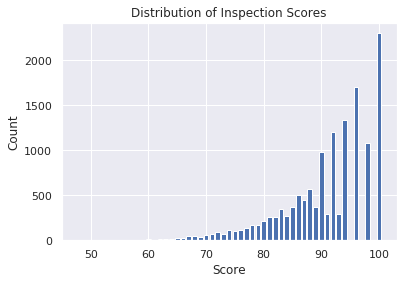

In [79]:
plt.bar(np.sort(ins['score'].unique()), list(ins.groupby('score').size()))
plt.xlabel('Score')
plt.ylabel('Count')
plt.title('Distribution of Inspection Scores')

### Question 6b

Describe the qualities of the distribution of the inspections scores based on your bar plot. Consider the mode(s), symmetry, tails, gaps, and anamolous values. Are there any unusual features of this distribution? What do your observations imply about the scores?

<!--
BEGIN QUESTION
name: q6b
points: 3
manual: True
-->
<!-- EXPORT TO PDF -->

*The distribution is skewed to the left and the tail of the distribution is longer on the left side than on the right side. Since the distribution is left-skewed, the mean of scores is less than the median of the scores. Left-skewness also signifies that the median of scores is closer to the third quartile than first quartile. Because the distribution is skewed, this means that there is no symmetry and that the distribution is instead asymmetric. In addition, the peaks of the histogram are the modes and the largest mode is of the score 100. The count inconsitently increases after the score of 90 and we therefore see gaps in the distribution.*




### Question 6c

Let's figure out which restaurants had the worst scores ever (single lowest score). Let's start by creating a new dataframe called `ins_named`. It should be exactly the same as `ins`, except that it should have the name and address of every business, as determined by the `bus` dataframe. If a `business_id` in `ins` does not exist in `bus`, the name and address should be given as NaN.

*Hint*: Use the merge method to join the `ins` dataframe with the appropriate portion of the `bus` dataframe. See the official [documentation](https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html) on how to use `merge`.

*Note*: For quick reference, a pandas 'left' join keeps the keys from the left frame, so if ins is the left frame, all the keys from ins are kept and if a set of these keys don't have matches in the other frame, the columns from the other frame for these "unmatched" key rows contains NaNs.

<!--
BEGIN QUESTION
name: q6c1
points: 1
-->

In [80]:
d = bus.drop(['longitude','latitude','city','state','postal_code_5','postal_code','phone_number'], axis=1)
ins_named = pd.merge(ins, d,  how='left')
ins_named.head()

,business_id,score,date,type,new_date,year,name,address
0,19,94,20160513,routine,2016-05-13,2016,NRGIZE LIFESTYLE CAFE,"1200 VAN NESS AVE, 3RD FLOOR"
1,19,94,20171211,routine,2017-12-11,2017,NRGIZE LIFESTYLE CAFE,"1200 VAN NESS AVE, 3RD FLOOR"
2,24,98,20171101,routine,2017-11-01,2017,OMNI S.F. HOTEL - 2ND FLOOR PANTRY,"500 CALIFORNIA ST, 2ND FLOOR"
3,24,98,20161005,routine,2016-10-05,2016,OMNI S.F. HOTEL - 2ND FLOOR PANTRY,"500 CALIFORNIA ST, 2ND FLOOR"
4,24,96,20160311,routine,2016-03-11,2016,OMNI S.F. HOTEL - 2ND FLOOR PANTRY,"500 CALIFORNIA ST, 2ND FLOOR"


In [81]:
ok.grade("q6c1");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 3
    Failed: 0
[ooooooooook] 100.0% passed



Using this data frame, identify the restaurant with the lowest inspection scores ever. Head to yelp.com and look up the reviews page for this restaurant. Copy and paste anything interesting you want to share.

<!--
BEGIN QUESTION
name: q6c2
points: 2
manual: True
-->
<!-- EXPORT TO PDF -->

*Da Cafe is the restaurant with the lowesr inspection scores ever. A yelp reviewer wrote : "Solid 4star hole in the style Chinese food...come for the 3 item dinner, don't expect great service but expect good food and fast".*

---
## 7: Restaurant Ratings Over Time

Let's consider various scenarios involving restaurants with multiple ratings over time.

### Question 7a

Let's see which restaurant has had the most extreme improvement in its rating, aka scores. Let the "swing" of a restaurant be defined as the difference between its highest-ever and lowest-ever rating. **Only consider restaurants with at least 3 ratings, aka rated for at least 3 times (3 scores)!** Using whatever technique you want to use, assign `max_swing` to the name of restaurant that has the maximum swing.

*Note*: The "swing" is of a specific business. There might be some restaurants with multiple locations; each location has its own "swing".

<!--
BEGIN QUESTION
name: q7a1
points: 2
-->

In [82]:
#np.ptp->Return the difference between the maximum value and the minimum value in the object

restaurants_3scores = (ins_named[ins_named.groupby("score")["score"].transform('size') >= 3])
names_score_diff = restaurants_3scores.groupby('name')['score'].agg(lambda x: np.ptp(x.to_numpy()))
max_diff_name_score = names_score_diff.nlargest(1)
max_swing = max_diff_name_score.index[0]
max_swing

"JOANIE'S DINER INC."

In [83]:
ok.grade("q7a1");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



### Question 7b

To get a sense of the number of times each restaurant has been inspected, create a multi-indexed dataframe called `inspections_by_id_and_year` where each row corresponds to data about a given business in a single year, and there is a single data column named `count` that represents the number of inspections for that business in that year. The first index in the MultiIndex should be on `business_id`, and the second should be on `year`.

An example row in this dataframe might look tell you that business_id is 573, year is 2017, and count is 4.

*Hint*: Use groupby to group based on both the `business_id` and the `year`.

*Hint*: Use rename to change the name of the column to `count`.

<!--
BEGIN QUESTION
name: q7b
points: 2
-->

In [84]:
inspections_by_id_and_year = ins.groupby(['business_id', 'year']).size().to_frame().rename(columns={0: "count"})
inspections_by_id_and_year.head()

count
business_id year       
19          2016      1
            2017      1
24          2016      2
            2017      1
31          2015      1

In [85]:
ok.grade("q7b");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 2
    Failed: 0
[ooooooooook] 100.0% passed



You should see that some businesses are inspected many times in a single year. Let's get a sense of the distribution of the counts of the number of inspections by calling `value_counts`. There are quite a lot of businesses with 2 inspections in the same year, so it seems like it might be interesting to see what we can learn from such businesses.

In [86]:
inspections_by_id_and_year['count'].value_counts()

1    9531
2    2175
3     111
4       2
Name: count, dtype: int64

### Question 7c

What's the relationship between the first and second scores for the businesses with 2 inspections in a year? Do they typically improve? For simplicity, let's focus on only 2016 for this problem, using `ins2016` data frame that will be created for you below. 

First, make a dataframe called `scores_pairs_by_business` indexed by `business_id` (containing only businesses with exactly 2 inspections in 2016).  This dataframe contains the field `score_pair` consisting of the score pairs **ordered chronologically**  `[first_score, second_score]`. 

Plot these scores. That is, make a scatter plot to display these pairs of scores. Include on the plot a reference line with slope 1. 

You may find the functions `sort_values`, `groupby`, `filter` and `agg` helpful, though not all necessary. 

The first few rows of the resulting table should look something like:

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>score_pair</th>
    </tr>
    <tr>
      <th>business_id</th>
      <th></th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>24</th>
      <td>[96, 98]</td>
    </tr>
    <tr>
      <th>45</th>
      <td>[78, 84]</td>
    </tr>
    <tr>
      <th>66</th>
      <td>[98, 100]</td>
    </tr>
    <tr>
      <th>67</th>
      <td>[87, 94]</td>
    </tr>
    <tr>
      <th>76</th>
      <td>[100, 98]</td>
    </tr>
  </tbody>
</table>

The scatter plot should look like this:

<img src="q7c2.png" width=500>

In the cell below, create `scores_pairs_by_business` as described above.

*Note: Each score pair must be a list type; numpy arrays will not pass the autograder.*

*Hint: Use the `filter` method from lecture 3 to create a new dataframe that only contains restaurants that received exactly 2 inspections.*

*Hint: Our code that creates the needed DataFrame is a single line of code that uses `sort_values`, `groupby`, `filter`, `groupby`, `agg`, and `rename` in that order. Your answer does not need to use these exact methods.*

<!--
BEGIN QUESTION
name: q7c1
points: 3
-->

In [87]:
# Create the dataframe here
ins2016 = ins[ins['year'] == 2016]

scores_pairs_by_business = ins2016.sort_values(by='date', ascending=True).groupby('business_id').filter(lambda x: len(x) == 2).groupby('business_id').agg({'score':lambda x: list(x)}).rename(columns={"score": "score_pair"})
scores_pairs_by_business

,score_pair
business_id,
24,"[96, 98]"
45,"[78, 84]"
66,"[98, 100]"
67,"[87, 94]"
76,"[100, 98]"
...,...
87761,"[86, 92]"
87802,"[91, 98]"
88323,"[75, 75]"


In [88]:
ok.grade("q7c1");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 2
    Failed: 0
[ooooooooook] 100.0% passed



Now, create your scatter plot in the cell below. It does not need to look exactly the same (e.g., no grid) as the above sample, but make sure that all labels, axes and data itself are correct.

Key pieces of syntax you'll need:
 + `plt.scatter` plots a set of points. Use `facecolors='none'` to make circle markers.
 + `plt.plot` for the reference line.
 + `plt.xlabel`, `plt.ylabel`, `plt.axis`, and `plt.title`.

*Note*: If you want to use another plotting library for your plots (e.g. `plotly`, `sns`) you are welcome to use that library instead so long as it works on DataHub.

*Hint*: You may find it convenient to use the `zip()` function to unzip scores in the list.
<!--
BEGIN QUESTION
name: q7c2
points: 3
manual: True
-->
<!-- EXPORT TO PDF -->

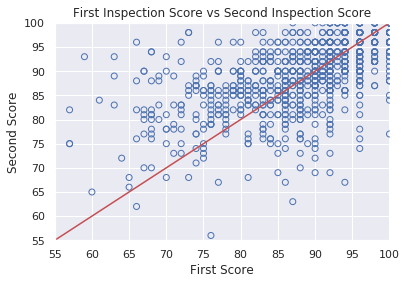

In [89]:
first_score = [row['score_pair'][0] for index,row in scores_pairs_by_business.iterrows()]
second_score = [row['score_pair'][1] for index,row in scores_pairs_by_business.iterrows()]
plt.scatter(first_score,second_score, facecolors='none',edgecolors='b')

plt.xlim(55,100) 
plt.ylim(55,100)


x_lim, y_lim = plt.ylim(), plt.xlim()
plt.plot(x_lim, y_lim, 'k-', color = 'r')
plt.ylim(y_lim)
plt.xlim(x_lim)



plt.xlabel("First Score")
plt.ylabel("Second Score")
plt.title('First Inspection Score vs Second Inspection Score')
plt.show()


### Question 7d

Another way to compare the scores from the two inspections is to examine the difference in scores. Subtract the first score from the second in `scores_pairs_by_business`. Make a histogram of these differences in the scores. We might expect these differences to be positive, indicating an improvement from the first to the second inspection.

The histogram should look like this:

<img src="q7d.png" width=500>

*Hint*: Use `second_score` and `first_score` created in the scatter plot code above.

*Hint*: Convert the scores into numpy arrays to make them easier to deal with.

*Hint*: Use `plt.hist()` Try changing the number of bins when you call `plt.hist()`.

<!--
BEGIN QUESTION
name: q7d
points: 2
manual: True
-->
<!-- EXPORT TO PDF -->

Text(0.5, 1.0, 'Distribution of Score Distributions')

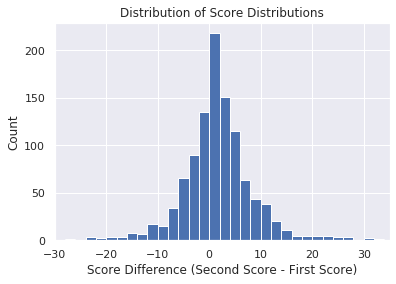

In [90]:
diff = [(row['score_pair'][1] - row['score_pair'][0]) for index,row in scores_pairs_by_business.iterrows()]
plt.hist(diff,bins=np.arange(-30,35,step = 2))
plt.xlim(-30, 35)
plt.xlabel('Score Difference (Second Score - First Score)')
plt.ylabel('Count')
plt.title('Distribution of Score Distributions')

### Question 7e

If a restaurant's score improves from the first to the second inspection, what do you expect to see in the scatter plot that you made in question 7c? What do you see?

If a restaurant's score improves from the first to the second inspection, how would this be reflected in the histogram of the difference in the scores that you made in question 7d? What do you see?

<!--
BEGIN QUESTION
name: q7e
points: 3
manual: True
-->
<!-- EXPORT TO PDF -->

*If a restaurant's score improves from the first to the second inspection, I expect to see all of the values plotted above the red line. The red line represents a net score of 0 so if a point is above it, it means there was an improvement from the first to second score. In the current scatter plot, the points are scattered above and below the red y=x line, meaning that there were scores that improved and scores that did not.*

*If a restaurant's score improved from the first to the second inspetion, the histogram's values would start to the right of 0 and thus the range of values would start at x=0. Score improvement also means that the histogram would be skewed to the right instead of being normally distributed. Currently, the histogram ranges from a score difference of -30 to a score difference a bit greater than 30.*

## Summary of the Inspections Data

What we have learned about the inspections data? What might be some next steps in our investigation? 

* We found that the records are at the inspection level and that we have inspections for multiple years.   
* We also found that many restaurants have more than one inspection a year. 
* By joining the business and inspection data, we identified the name of the restaurant with the worst rating and optionally the names of the restaurants with the best rating.
* We identified the restaurant that had the largest swing in rating over time.
* We also examined the relationship between the scores when a restaurant has multiple inspections in a year. Our findings were a bit counterintuitive and may warrant further investigation. 


## Congratulations!

You are finished with Project 1.

# Submit
Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output.
**Please save before submitting!**

<!-- EXPECT 13 EXPORTED QUESTIONS -->

In [ ]:
# Save your notebook first, then run this cell to submit.
import jassign.to_pdf
jassign.to_pdf.generate_pdf('proj1.ipynb', 'proj1.pdf')
ok.submit()

Generating PDF...
Saved proj1.pdf


<IPython.core.display.Javascript object>